<a href="https://colab.research.google.com/github/MoatazM1/CAS_ADS_M6/blob/main/Sorting_M6_Tobi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas numpy scikit-learn tensorflow matplotlib


# Train a model on a single chute taking into account zip code and package count

To start off we determined that working on a single chute would be most reasonable to get an overview on how the model performs, what the predictions looks like etc.
Firstly we tried RNN (Recurrent Neural Network) for our model.


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0217
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0146
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0103
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0085
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0082
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0082
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0079
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0071
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0062
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0054


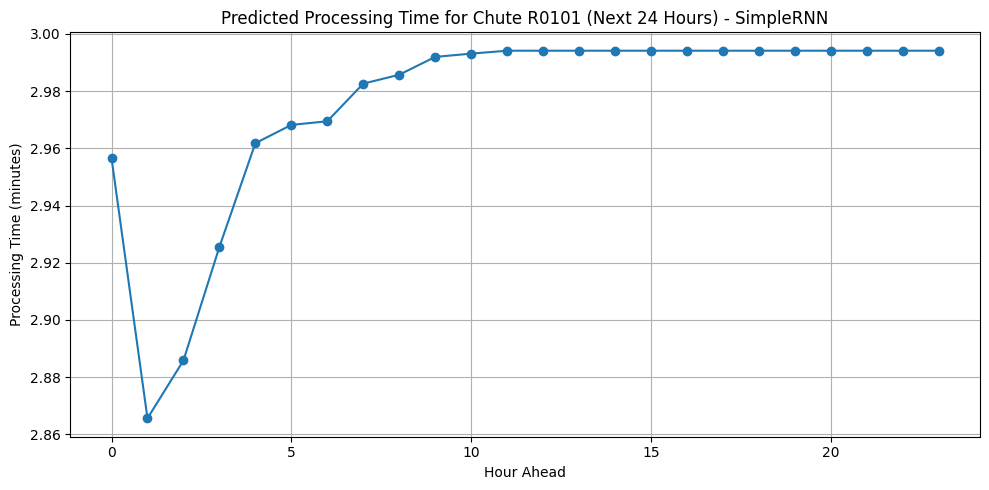

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

# ========== LOAD DATA ==========
df = pd.read_csv('data4day.csv')

# Parse datetime
df['HOUR_TIME'] = pd.to_datetime(df['HOUR_TIME'], format="%Y-%m-%d %H")

# ========== FILTER ONE CHUTE ==========
chute_id = 'R0101'  # Change this if needed
df = df[df['CHUTE'] == chute_id]

# ========== AGGREGATE DATA HOURLY ==========
df_hourly = df.groupby('HOUR_TIME').agg({
    'PACKAGE_COUNT': 'sum',
    'AVG_PROCESSING_TIME_MINUTES': 'mean'
}).reset_index()

# Use most common ZIP per hour
zip_mode = df.groupby('HOUR_TIME')['ZIP_CODE'].agg(lambda x: x.mode()[0])
df_hourly['ZIP_CODE'] = df_hourly['HOUR_TIME'].map(zip_mode)

# Add time features
df_hourly['HOUR'] = df_hourly['HOUR_TIME'].dt.hour
df_hourly['DAY_OF_WEEK'] = df_hourly['HOUR_TIME'].dt.dayofweek

# Encode ZIP code
zip_encoder = LabelEncoder()
df_hourly['ZIP_CODE_ENC'] = zip_encoder.fit_transform(df_hourly['ZIP_CODE'])

# ========== PREPARE DATA ==========
features = ['ZIP_CODE_ENC', 'PACKAGE_COUNT', 'HOUR', 'DAY_OF_WEEK']
target = 'AVG_PROCESSING_TIME_MINUTES'

# Normalize features and target
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df_hourly[features])

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(df_hourly[[target]])

# Create time series generator
sequence_length = 12
generator = TimeseriesGenerator(X_scaled, y_scaled, length=sequence_length, batch_size=32)

# ========== BUILD & TRAIN RNN MODEL ==========
model = Sequential()
model.add(SimpleRNN(64, activation='relu', input_shape=(sequence_length, len(features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(generator, epochs=10, verbose=1)

# ========== PREDICT NEXT 24 HOURS ==========
last_seq = X_scaled[-sequence_length:]
last_seq = np.expand_dims(last_seq, axis=0)
future_preds = []

for _ in range(24):
    pred = model.predict(last_seq, verbose=0)[0][0]
    future_preds.append(pred)

    # Simulate future input
    next_input = last_seq[0][1:]  # shift left
    next_input = np.vstack([next_input, last_seq[0, -1]])  # repeat last row
    last_seq = np.expand_dims(next_input, axis=0)

# Inverse scale predictions
future_preds = scaler_y.inverse_transform(np.array(future_preds).reshape(-1, 1))

# ========== PLOT ==========
plt.figure(figsize=(10, 5))
plt.plot(future_preds, marker='o')
plt.title(f'Predicted Processing Time for Chute {chute_id} (Next 24 Hours) - SimpleRNN')
plt.xlabel('Hour Ahead')
plt.ylabel('Processing Time (minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()


The predicted processing time seems to plateau after approximately 6-8 hours in the future and overall the times seem to be very (!) close together

# LSTM vs. RNN

Since LSTM compared to RNN handles longer sequences (for example forcasting for more hours) and more complex patterns better. We decided to compare a since chute forcast between the two models to settle for the one that is better suited for our needs.

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1159
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0966
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0793
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0643
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0511
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0399
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0302
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.0217
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0150
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0102


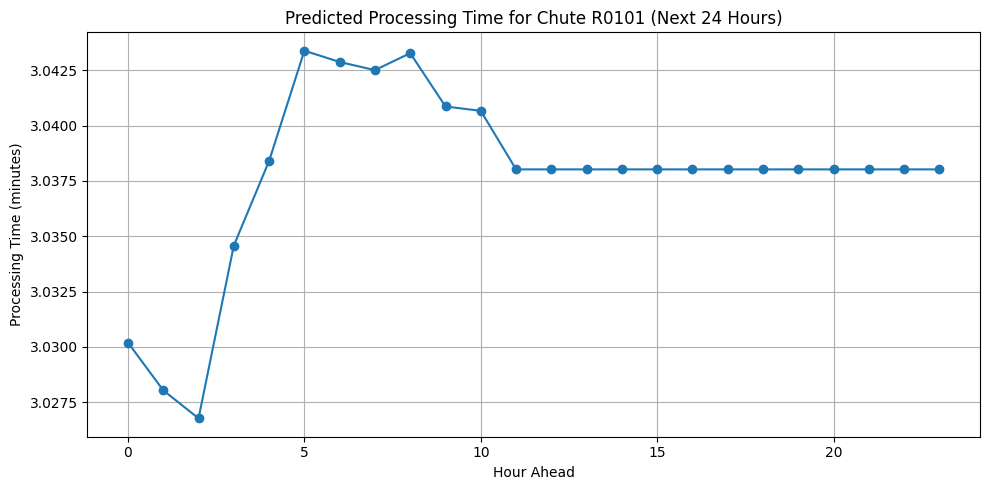

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

# ========== LOAD DATA ==========
# Replace this path with your actual file path
df = pd.read_csv('data4day.csv')

# Parse datetime
df['HOUR_TIME'] = pd.to_datetime(df['HOUR_TIME'], format="%Y-%m-%d %H")

# ========== FILTER ONE CHUTE ==========
chute_id = 'R0101'  # Change this if needed
df = df[df['CHUTE'] == chute_id]

# ========== AGGREGATE DATA HOURLY ==========
df_hourly = df.groupby('HOUR_TIME').agg({
    'PACKAGE_COUNT': 'sum',
    'AVG_PROCESSING_TIME_MINUTES': 'mean'
}).reset_index()

# Use most common ZIP per hour
zip_mode = df.groupby('HOUR_TIME')['ZIP_CODE'].agg(lambda x: x.mode()[0])
df_hourly['ZIP_CODE'] = df_hourly['HOUR_TIME'].map(zip_mode)

# Add time features
df_hourly['HOUR'] = df_hourly['HOUR_TIME'].dt.hour
df_hourly['DAY_OF_WEEK'] = df_hourly['HOUR_TIME'].dt.dayofweek

# Encode ZIP code
zip_encoder = LabelEncoder()
df_hourly['ZIP_CODE_ENC'] = zip_encoder.fit_transform(df_hourly['ZIP_CODE'])

# ========== PREPARE DATA ==========
features = ['ZIP_CODE_ENC', 'PACKAGE_COUNT', 'HOUR', 'DAY_OF_WEEK']
target = 'AVG_PROCESSING_TIME_MINUTES'

# Normalize features and target
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df_hourly[features])

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(df_hourly[[target]])

# Create time series generator
sequence_length = 12
generator = TimeseriesGenerator(X_scaled, y_scaled, length=sequence_length, batch_size=32)

# ========== BUILD & TRAIN LSTM MODEL ==========
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, len(features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(generator, epochs=10, verbose=1)

# ========== PREDICT NEXT 24 HOURS ==========
last_seq = X_scaled[-sequence_length:]
last_seq = np.expand_dims(last_seq, axis=0)
future_preds = []

for _ in range(24):
    pred = model.predict(last_seq, verbose=0)[0][0]
    future_preds.append(pred)

    next_input = last_seq[0][1:]  # shift left
    next_input = np.vstack([next_input, last_seq[0, -1]])  # repeat last row
    last_seq = np.expand_dims(next_input, axis=0)

# Inverse scale predictions
future_preds = scaler_y.inverse_transform(np.array(future_preds).reshape(-1, 1))

# ========== PLOT ==========
plt.figure(figsize=(10, 5))
plt.plot(future_preds, marker='o')
plt.title(f'Predicted Processing Time for Chute {chute_id} (Next 24 Hours)')
plt.xlabel('Hour Ahead')
plt.ylabel('Processing Time (minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()


Similar to the RNN model this also predicts times ver close together however it looks like it has more variation for a longer prediction. Due to that we settled for LSTM.

#LSTM: Train a different model for each individual chute

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/traine

Skipping R0113: Not enough data (12 rows)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/traine

Skipping R3527: Not enough data (9 rows)
Skipping R3528: Not enough data (6 rows)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/traine

Skipping R2526: Not enough data (4 rows)


<ipython-input-15-ae8273c2f9d6>:93: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


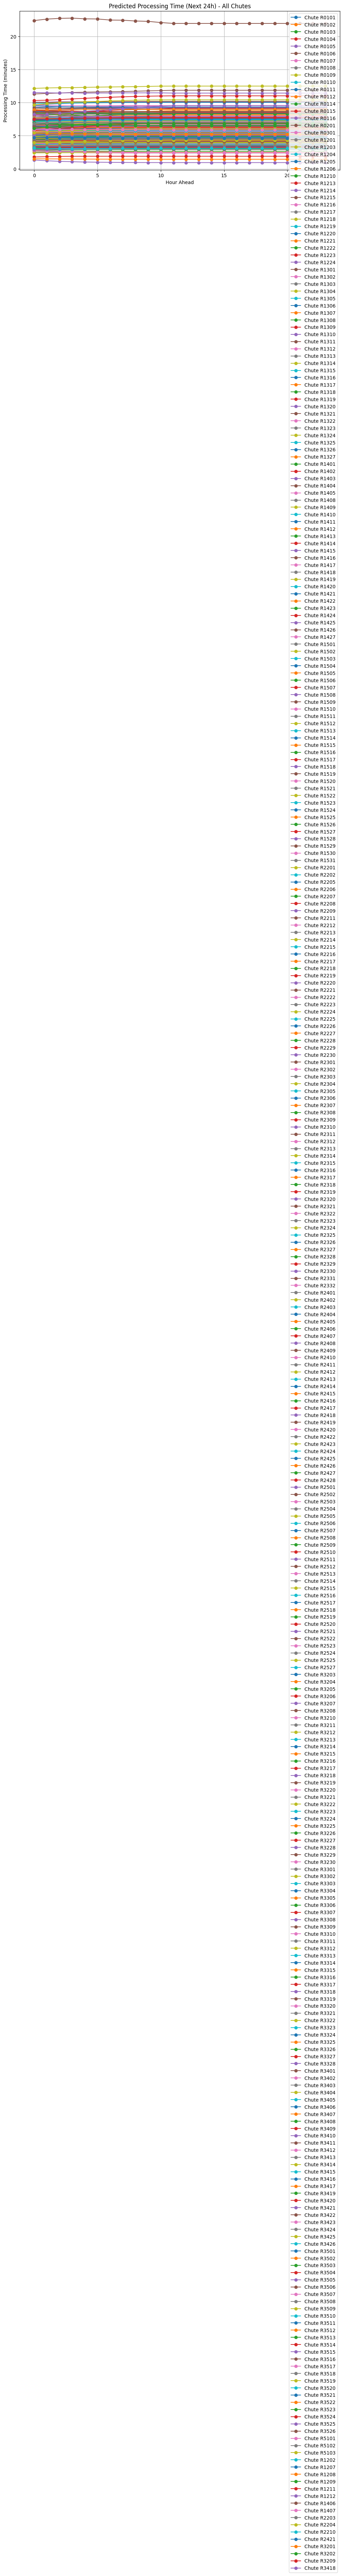

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

# ========== LOAD DATA ==========
df = pd.read_csv('data4day.csv')
df['HOUR_TIME'] = pd.to_datetime(df['HOUR_TIME'], format="%Y-%m-%d %H")

# ========== GET LIST OF CHUTES ==========
chutes = df['CHUTE'].unique()
sequence_length = 12
results = {}

# ========== PROCESS EACH CHUTE ==========
for chute_id in chutes:
    df_chute = df[df['CHUTE'] == chute_id].copy()

    # Aggregate hourly
    df_hourly = df_chute.groupby('HOUR_TIME').agg({
        'PACKAGE_COUNT': 'sum',
        'AVG_PROCESSING_TIME_MINUTES': 'mean'
    }).reset_index()

    # Skip chutes with not enough data
    if len(df_hourly) <= sequence_length:
        print(f"Skipping {chute_id}: Not enough data ({len(df_hourly)} rows)")
        continue

    # Most frequent ZIP per hour
    zip_mode = df_chute.groupby('HOUR_TIME')['ZIP_CODE'].agg(lambda x: x.mode()[0])
    df_hourly['ZIP_CODE'] = df_hourly['HOUR_TIME'].map(zip_mode)

    # Time features
    df_hourly['HOUR'] = df_hourly['HOUR_TIME'].dt.hour
    df_hourly['DAY_OF_WEEK'] = df_hourly['HOUR_TIME'].dt.dayofweek

    # Encode ZIP
    zip_encoder = LabelEncoder()
    df_hourly['ZIP_CODE_ENC'] = zip_encoder.fit_transform(df_hourly['ZIP_CODE'])

    # Normalize features
    features = ['ZIP_CODE_ENC', 'PACKAGE_COUNT', 'HOUR', 'DAY_OF_WEEK']
    target = 'AVG_PROCESSING_TIME_MINUTES'

    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(df_hourly[features])

    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(df_hourly[[target]])

    # Time series generator
    generator = TimeseriesGenerator(X_scaled, y_scaled, length=sequence_length, batch_size=32)

    # Build and train model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(sequence_length, len(features))))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(generator, epochs=10, verbose=0)

    # Predict next 24 hours
    last_seq = X_scaled[-sequence_length:]
    last_seq = np.expand_dims(last_seq, axis=0)
    future_preds = []

    for _ in range(24):
        pred = model.predict(last_seq, verbose=0)[0][0]
        future_preds.append(pred)

        # Simulate next input (use last known input)
        next_input = last_seq[0][1:]
        next_input = np.vstack([next_input, last_seq[0, -1]])  # repeat last row
        last_seq = np.expand_dims(next_input, axis=0)

    # Inverse transform predictions
    future_preds = scaler_y.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()
    results[chute_id] = future_preds

# ========== DISPLAY ALL CHUTES IN ONE PLOT ==========
plt.figure(figsize=(12, 6))
for chute_id, preds in results.items():
    plt.plot(preds, label=f'Chute {chute_id}', marker='o')

plt.title('Predicted Processing Time (Next 24h) - All Chutes')
plt.xlabel('Hour Ahead')
plt.ylabel('Processing Time (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Multi-Chute Prediction with Threshold 10 Minutes
Compare multi-chute prediction to the previous one, as this reduces run time by a lot by assuming that all the chutes are very similar and base the prediction off all the chutes on a single one. This means the model really only has to be run once for one chute.
To minimize the clutter in the plot we decided to only print the chutes which reach the threshold of 10 minutes for the average processing time at least once during the predicted hours.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
import tensorflow as tf

# Load data
df = pd.read_csv('data4day.csv')
df['HOUR_TIME'] = pd.to_datetime(df['HOUR_TIME'], format="%Y-%m-%d %H")

# Time features
df['HOUR'] = df['HOUR_TIME'].dt.hour
df['DAY_OF_WEEK'] = df['HOUR_TIME'].dt.dayofweek

# Encode CHUTE and ZIP_CODE
chute_encoder = LabelEncoder()
zip_encoder = LabelEncoder()
df['CHUTE_ENC'] = chute_encoder.fit_transform(df['CHUTE'])
df['ZIP_CODE_ENC'] = zip_encoder.fit_transform(df['ZIP_CODE'])

# Aggregate per hour per chute
df_hourly = df.groupby(['HOUR_TIME', 'CHUTE_ENC']).agg({
    'ZIP_CODE_ENC': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'PACKAGE_COUNT': 'sum',
    'AVG_PROCESSING_TIME_MINUTES': 'mean'
}).reset_index()

# Add time features
df_hourly = df_hourly.merge(df[['HOUR_TIME', 'HOUR', 'DAY_OF_WEEK']].drop_duplicates(), on='HOUR_TIME')

# Features & target
features = ['CHUTE_ENC', 'ZIP_CODE_ENC', 'PACKAGE_COUNT', 'HOUR', 'DAY_OF_WEEK']
target = 'AVG_PROCESSING_TIME_MINUTES'

# Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df_hourly[features])
y_scaled = scaler_y.fit_transform(df_hourly[[target]])

# Sequence generator
sequence_length = 12
generator = TimeseriesGenerator(X_scaled, y_scaled, length=sequence_length, batch_size=32)

# Build and train model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, len(features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(generator, epochs=10, verbose=1)

# Save model
model.save('multi_chute_congestion_model.h5')
print("✅ Model saved as 'multi_chute_congestion_model.h5'")

# Prediction for each chute
congestion_threshold = 10
results = {}

for chute_enc in df_hourly['CHUTE_ENC'].unique():
    df_chute = df_hourly[df_hourly['CHUTE_ENC'] == chute_enc].copy()
    if len(df_chute) <= sequence_length:
        continue

    X_chute = scaler_X.transform(df_chute[features])
    last_seq = X_chute[-sequence_length:]
    last_seq = np.expand_dims(last_seq, axis=0)
    future_preds = []

    for _ in range(24):
        pred = model.predict(last_seq, verbose=0)[0][0]
        future_preds.append(pred)

        next_input = last_seq[0][1:]
        next_input = np.vstack([next_input, last_seq[0, -1]])  # repeat last
        last_seq = np.expand_dims(next_input, axis=0)

    preds_rescaled = scaler_y.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()
    chute_id = chute_encoder.inverse_transform([chute_enc])[0]
    congestion_flags = preds_rescaled > congestion_threshold

    if np.any(congestion_flags):
        results[chute_id] = preds_rescaled

# Plot all congested chutes on one plot
if results:
    plt.figure(figsize=(12, 6))
    for chute_id, preds in results.items():
        plt.plot(preds, label=f'Chute {chute_id}')
    plt.axhline(congestion_threshold, color='red', linestyle='--', label='Congestion Threshold')
    plt.title('Predicted Processing Time (Next 24 Hours) - Congested Chutes Only')
    plt.xlabel('Hour Ahead')
    plt.ylabel('Processing Time (min)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("✅ No chutes predicted to exceed congestion threshold.")


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0061
Epoch 2/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0060
Epoch 3/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0058
Epoch 4/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0050
Epoch 5/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0043
Epoch 6/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0059
Epoch 7/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0045
Epoch 8/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0052
Epoch 9/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0056
Epoch 10/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0042


✅ Model saved as 'multi_chute_congestion_model.h5'
✅ No chutes predicted to exceed congestion threshold.


For the **threshold = 10 min** no congestions have been detected so we repeat the process for a lower threshold and observe the results.

# Same but with Threshold = 7.5 mins

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0071
Epoch 2/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0061
Epoch 3/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0048
Epoch 4/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0057
Epoch 5/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0056
Epoch 6/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0059
Epoch 7/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0048
Epoch 8/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0047
Epoch 9/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0055
Epoch 10/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0051


✅ Model saved as 'multi_chute_congestion_model.h5'


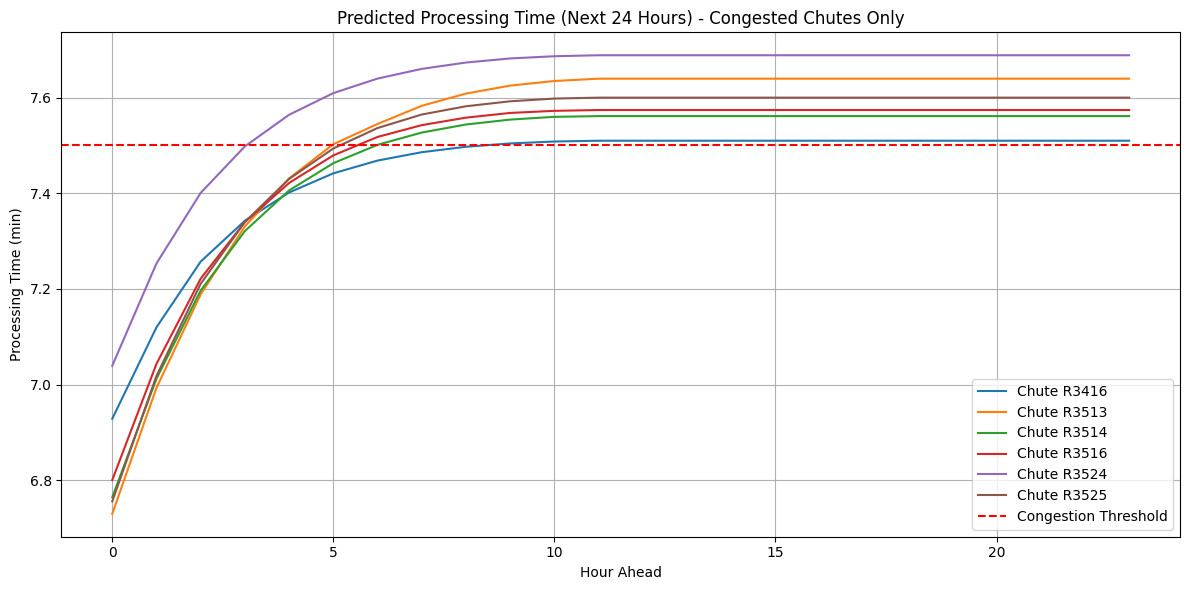

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
import tensorflow as tf

# Load data
df = pd.read_csv('data4day.csv')
df['HOUR_TIME'] = pd.to_datetime(df['HOUR_TIME'], format="%Y-%m-%d %H")

# Time features
df['HOUR'] = df['HOUR_TIME'].dt.hour
df['DAY_OF_WEEK'] = df['HOUR_TIME'].dt.dayofweek

# Encode CHUTE and ZIP_CODE
chute_encoder = LabelEncoder()
zip_encoder = LabelEncoder()
df['CHUTE_ENC'] = chute_encoder.fit_transform(df['CHUTE'])
df['ZIP_CODE_ENC'] = zip_encoder.fit_transform(df['ZIP_CODE'])

# Aggregate per hour per chute
df_hourly = df.groupby(['HOUR_TIME', 'CHUTE_ENC']).agg({
    'ZIP_CODE_ENC': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'PACKAGE_COUNT': 'sum',
    'AVG_PROCESSING_TIME_MINUTES': 'mean'
}).reset_index()

# Add time features
df_hourly = df_hourly.merge(df[['HOUR_TIME', 'HOUR', 'DAY_OF_WEEK']].drop_duplicates(), on='HOUR_TIME')

# Features & target
features = ['CHUTE_ENC', 'ZIP_CODE_ENC', 'PACKAGE_COUNT', 'HOUR', 'DAY_OF_WEEK']
target = 'AVG_PROCESSING_TIME_MINUTES'

# Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df_hourly[features])
y_scaled = scaler_y.fit_transform(df_hourly[[target]])

# Sequence generator
sequence_length = 12
generator = TimeseriesGenerator(X_scaled, y_scaled, length=sequence_length, batch_size=32)

# Build and train model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, len(features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(generator, epochs=10, verbose=1)

# Save model
model.save('multi_chute_congestion_model.h5')
print("✅ Model saved as 'multi_chute_congestion_model.h5'")

# Prediction for each chute
congestion_threshold = 7.5
results = {}

for chute_enc in df_hourly['CHUTE_ENC'].unique():
    df_chute = df_hourly[df_hourly['CHUTE_ENC'] == chute_enc].copy()
    if len(df_chute) <= sequence_length:
        continue

    X_chute = scaler_X.transform(df_chute[features])
    last_seq = X_chute[-sequence_length:]
    last_seq = np.expand_dims(last_seq, axis=0)
    future_preds = []

    for _ in range(24):
        pred = model.predict(last_seq, verbose=0)[0][0]
        future_preds.append(pred)

        next_input = last_seq[0][1:]
        next_input = np.vstack([next_input, last_seq[0, -1]])  # repeat last
        last_seq = np.expand_dims(next_input, axis=0)

    preds_rescaled = scaler_y.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()
    chute_id = chute_encoder.inverse_transform([chute_enc])[0]
    congestion_flags = preds_rescaled > congestion_threshold

    if np.any(congestion_flags):
        results[chute_id] = preds_rescaled

# Plot all congested chutes on one plot
if results:
    plt.figure(figsize=(12, 6))
    for chute_id, preds in results.items():
        plt.plot(preds, label=f'Chute {chute_id}')
    plt.axhline(congestion_threshold, color='red', linestyle='--', label='Congestion Threshold')
    plt.title('Predicted Processing Time (Next 24 Hours) - Congested Chutes Only')
    plt.xlabel('Hour Ahead')
    plt.ylabel('Processing Time (min)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("✅ No chutes predicted to exceed congestion threshold.")


Interestingly the predicted processing times seem to gradually increase and then pleateau for all of the chutes. This leads to a question if this also happens to the model if we use RNN or if this is a LSTM specific symptom

# Do Multi-chute Prediction with threshold = 7.5 min

Epoch 5/20, Loss: 0.0058
Epoch 10/20, Loss: 0.0054
Epoch 15/20, Loss: 0.0052
Epoch 20/20, Loss: 0.0051
✅ Model saved to 'multi_chute_rnn_model.pt'


<ipython-input-5-8fdbb312dcca>:139: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


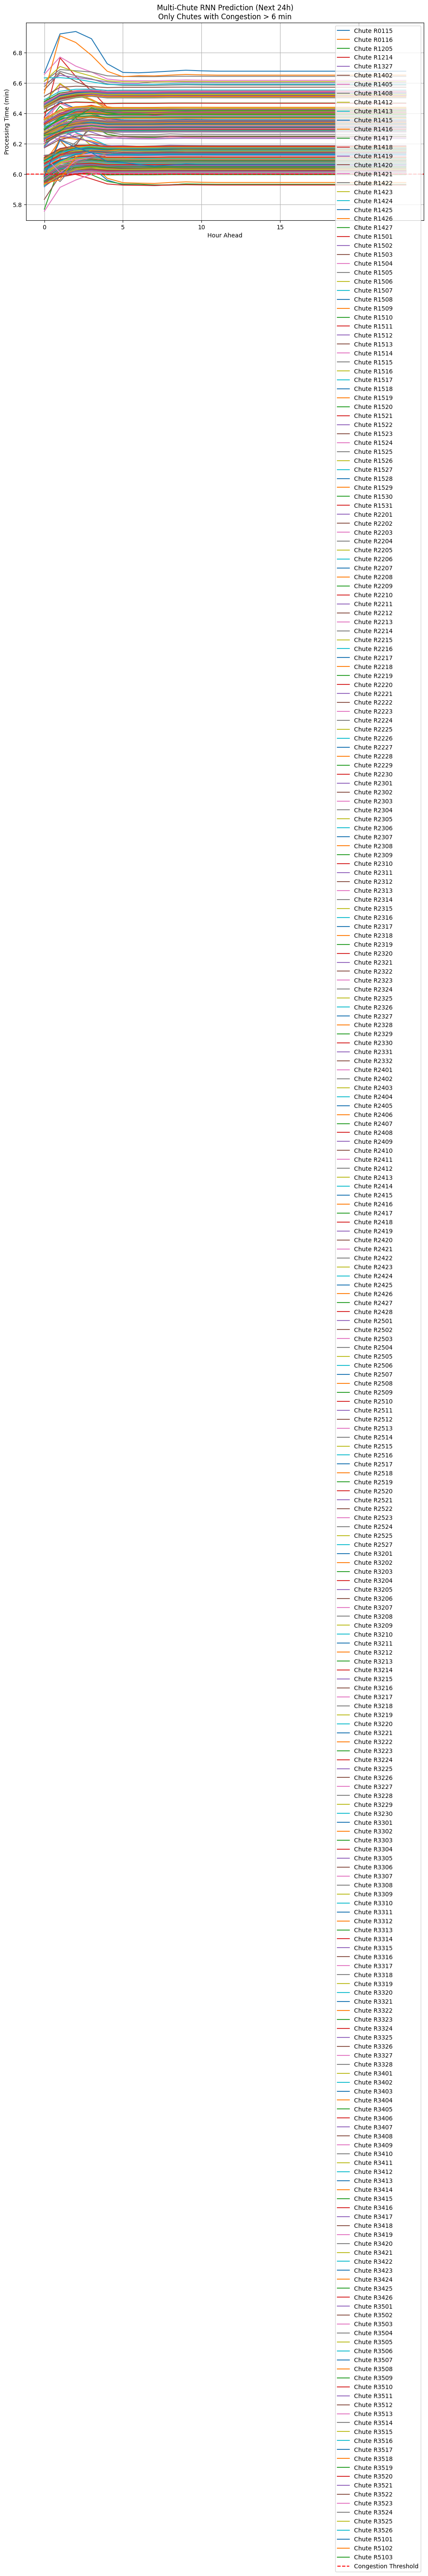

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from datetime import timedelta

# ========== CONFIG ==========
SEQUENCE_LENGTH = 12
PREDICTION_HORIZON = 24
EPOCHS = 20
CONGESTION_THRESHOLD = 6
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_SAVE_PATH = 'multi_chute_rnn_model.pt'

# ========== LOAD DATA ==========
df = pd.read_csv('data4day.csv')
df['HOUR_TIME'] = pd.to_datetime(df['HOUR_TIME'], format="%Y-%m-%d %H")

# Time features
df['HOUR'] = df['HOUR_TIME'].dt.hour
df['DAY_OF_WEEK'] = df['HOUR_TIME'].dt.dayofweek

# Encode CHUTE and ZIP
chute_encoder = LabelEncoder()
zip_encoder = LabelEncoder()
df['CHUTE_ENC'] = chute_encoder.fit_transform(df['CHUTE'])
df['ZIP_CODE_ENC'] = zip_encoder.fit_transform(df['ZIP_CODE'])

# Aggregate hourly data per chute
df_hourly = df.groupby(['HOUR_TIME', 'CHUTE_ENC']).agg({
    'ZIP_CODE_ENC': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'PACKAGE_COUNT': 'sum',
    'AVG_PROCESSING_TIME_MINUTES': 'mean'
}).reset_index()

# Add time features back
df_hourly = df_hourly.merge(
    df[['HOUR_TIME', 'HOUR', 'DAY_OF_WEEK']].drop_duplicates(),
    on='HOUR_TIME'
)

# Features and target
features = ['CHUTE_ENC', 'ZIP_CODE_ENC', 'PACKAGE_COUNT', 'HOUR', 'DAY_OF_WEEK']
target = 'AVG_PROCESSING_TIME_MINUTES'

# Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df_hourly[features])
y_scaled = scaler_y.fit_transform(df_hourly[[target]])

# Create sequences
def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQUENCE_LENGTH)

# Convert to tensors
X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(DEVICE)
y_tensor = torch.tensor(y_seq, dtype=torch.float32).to(DEVICE)

# ========== RNN MODEL ==========
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        last = out[:, -1, :]
        return self.fc(last)

model = RNNModel(input_size=X_tensor.shape[2]).to(DEVICE)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ========== TRAIN ==========
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    pred = model(X_tensor)
    loss = loss_fn(pred, y_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

# Save model
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"✅ Model saved to '{MODEL_SAVE_PATH}'")

# ========== PREDICT FOR EACH CHUTE ==========
results = {}
for chute_enc in df_hourly['CHUTE_ENC'].unique():
    df_chute = df_hourly[df_hourly['CHUTE_ENC'] == chute_enc].copy()
    if len(df_chute) <= SEQUENCE_LENGTH:
        continue

    X_chute = scaler_X.transform(df_chute[features])
    last_seq = X_chute[-SEQUENCE_LENGTH:]
    last_seq = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    future_preds = []
    for _ in range(PREDICTION_HORIZON):
        with torch.no_grad():
            pred = model(last_seq).item()
            future_preds.append(pred)

        # Simulate next input (repeat last row)
        next_input = last_seq[0, 1:, :].cpu().numpy()
        last_row = last_seq[0, -1, :].cpu().numpy()
        next_input = np.vstack([next_input, last_row])
        last_seq = torch.tensor(next_input, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    preds_rescaled = scaler_y.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()
    chute_id = chute_encoder.inverse_transform([chute_enc])[0]

    if np.any(preds_rescaled > CONGESTION_THRESHOLD):
        results[chute_id] = preds_rescaled

# ========== PLOT ONLY CONGESTED CHUTES ==========
if results:
    plt.figure(figsize=(12, 6))
    for chute_id, preds in results.items():
        plt.plot(preds, label=f'Chute {chute_id}')
    plt.axhline(CONGESTION_THRESHOLD, color='red', linestyle='--', label='Congestion Threshold')
    plt.title(f"Multi-Chute RNN Prediction (Next 24h)\nOnly Chutes with Congestion > {CONGESTION_THRESHOLD} min")
    plt.xlabel("Hour Ahead")
    plt.ylabel("Processing Time (min)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("✅ No chutes are predicted to exceed the congestion threshold.")


Though there seems to be more variation during the first 5 hours, still the plateauing effect is ver visible. Thus we deducted that the issue must lie within the data that we use.

# Enriched Dataset with Lag and Rolling Means

**Using feature engineering we decided to add more features to the data set by adding lag and rolling means.**

*PACKAGE_COUNT_LAG_1: the package count 1 hour ago*

*PROCESSING_TIME_LAG_3: the processing time 3 hours ago*

*PACKAGE_COUNT_ROLL_MEAN_3: average over the last 3 hours*

*PROCESSING_TIME_ROLL_MEAN_6: average over the last 6 hours*

*And the same for the PACKAGE_COUNT*

This allows us to increase the number features used by the model from previously 5 to 15

In [ ]:
import pandas as pd

# Load the raw dataset
df = pd.read_csv('data4day.csv')
df['HOUR_TIME'] = pd.to_datetime(df['HOUR_TIME'], format="%Y-%m-%d %H")

# Sort data for time-series consistency
df.sort_values(by=['CHUTE', 'HOUR_TIME'], inplace=True)

# Add time-based features
df['HOUR'] = df['HOUR_TIME'].dt.hour
df['DAY_OF_WEEK'] = df['HOUR_TIME'].dt.dayofweek

# Define lag and rolling windows
lag_features = [1, 2, 3]
rolling_windows = [3, 6]

# Initialize enriched dataset
enriched_df = df.copy()

# Apply lag and rolling features per chute
for chute in enriched_df['CHUTE'].unique():
    chute_df = enriched_df[enriched_df['CHUTE'] == chute].copy()

    for lag in lag_features:
        enriched_df.loc[enriched_df['CHUTE'] == chute, f'PACKAGE_COUNT_LAG_{lag}'] = chute_df['PACKAGE_COUNT'].shift(lag)
        enriched_df.loc[enriched_df['CHUTE'] == chute, f'PROCESSING_TIME_LAG_{lag}'] = chute_df['AVG_PROCESSING_TIME_MINUTES'].shift(lag)

    for window in rolling_windows:
        enriched_df.loc[enriched_df['CHUTE'] == chute, f'PACKAGE_COUNT_ROLL_MEAN_{window}'] = chute_df['PACKAGE_COUNT'].rolling(window).mean()
        enriched_df.loc[enriched_df['CHUTE'] == chute, f'PROCESSING_TIME_ROLL_MEAN_{window}'] = chute_df['AVG_PROCESSING_TIME_MINUTES'].rolling(window).mean()

# Drop rows with missing values introduced by lag/rolling
enriched_df.dropna(inplace=True)




In [ ]:
import pandas as pd

# Load the updated enriched dataset
#enriched_df = pd.read_csv('Updated_Enriched_DataFrame.csv')

# Convert time column to datetime
enriched_df['HOUR_TIME'] = pd.to_datetime(enriched_df['HOUR_TIME'], format="%Y-%m-%d %H:%M:%S")

# Show basic info and head
enriched_df.info(), enriched_df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 142706 entries, 5 to 144173
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   HOUR_TIME                    142706 non-null  datetime64[ns]
 1   CODS_ZENT_NR                 142706 non-null  int64         
 2   CHUTE                        142706 non-null  object        
 3   ZIP_CODE                     142706 non-null  int64         
 4   PACKAGE_COUNT                142706 non-null  int64         
 5   AVG_PROCESSING_TIME_MINUTES  142706 non-null  float64       
 6   HOUR                         142706 non-null  int32         
 7   DAY_OF_WEEK                  142706 non-null  int32         
 8   PACKAGE_COUNT_LAG_1          142706 non-null  float64       
 9   PROCESSING_TIME_LAG_1        142706 non-null  float64       
 10  PACKAGE_COUNT_LAG_2          142706 non-null  float64       
 11  PROCESSING_TIME_LAG_2        14

(None,
             HOUR_TIME  CODS_ZENT_NR  CHUTE  ZIP_CODE  PACKAGE_COUNT  \
 5 2025-03-18 18:00:00             2  R0101    804400              4   
 6 2025-03-18 18:00:00             2  R0101    804600              5   
 7 2025-03-18 18:00:00             2  R0101    804900              2   
 8 2025-03-18 18:00:00             2  R0101    805000             16   
 9 2025-03-18 18:00:00             2  R0101    805100              9   
 
    AVG_PROCESSING_TIME_MINUTES  HOUR  DAY_OF_WEEK  PACKAGE_COUNT_LAG_1  \
 5                     1.337500    18            1                  4.0   
 6                     1.560000    18            1                  4.0   
 7                     1.283333    18            1                  5.0   
 8                     1.551042    18            1                  2.0   
 9                     1.520370    18            1                 16.0   
 
    PROCESSING_TIME_LAG_1  PACKAGE_COUNT_LAG_2  PROCESSING_TIME_LAG_2  \
 5               1.662500         

This is for setting up the inputs which we will use for the following models

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# === Load and Parse CSV ===

enriched_df['HOUR_TIME'] = pd.to_datetime(enriched_df['HOUR_TIME'], format="%Y-%m-%d %H:%M:%S")

# === Encode Categorical Features ===
chute_encoder = LabelEncoder()
zip_encoder = LabelEncoder()
enriched_df['CHUTE_ENC'] = chute_encoder.fit_transform(enriched_df['CHUTE'])
enriched_df['ZIP_CODE_ENC'] = zip_encoder.fit_transform(enriched_df['ZIP_CODE'])

# === Define Feature Set ===
lag_roll_features = [col for col in enriched_df.columns if 'LAG' in col or 'ROLL_MEAN' in col]
final_features = ['CHUTE_ENC', 'ZIP_CODE_ENC', 'PACKAGE_COUNT', 'HOUR', 'DAY_OF_WEEK'] + lag_roll_features
target_col = 'AVG_PROCESSING_TIME_MINUTES'

# === Drop any rows with missing values ===
df_clean = enriched_df.dropna(subset=final_features + [target_col]).copy()

# === Normalize Features and Target ===
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df_clean[final_features])
y_scaled = scaler_y.fit_transform(df_clean[[target_col]])

# === Create Sequences for LSTM ===
def create_sequences(X, y, seq_len=12):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len=12)

# === Print Results ===
print(f"✅ Data Ready: {X_seq.shape[0]} samples, each with {X_seq.shape[1]} time steps and {X_seq.shape[2]} features.")


✅ Data Ready: 142694 samples, each with 12 time steps and 15 features.


Here we simply run the multi-chute model with the newly enigneered features and save the model to that we do not have to run it again and instead can call it via the "enhanced_lstm_model.pt" file

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import os

# ========== CONFIG ==========
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SEQ_LEN = X_seq.shape[1]
INPUT_SIZE = X_seq.shape[2]
HIDDEN_SIZE = 64
EPOCHS = 20
BATCH_SIZE = 64
MODEL_PATH = "enhanced_lstm_model.pt"

# ========== CONVERT TO TENSORS ==========
X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(DEVICE)
y_tensor = torch.tensor(y_seq, dtype=torch.float32).to(DEVICE)
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# ========== DEFINE LSTM MODEL ==========
class EnhancedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EnhancedLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

model = EnhancedLSTM(INPUT_SIZE, HIDDEN_SIZE).to(DEVICE)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ========== TRAIN MODEL ==========
print("🚀 Training Enhanced LSTM Model...")
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.6f}")

# ========== SAVE MODEL ==========
torch.save(model.state_dict(), MODEL_PATH)
print(f"\n✅ Model saved to '{MODEL_PATH}'")


🚀 Training Enhanced LSTM Model...
Epoch 1/20 - Loss: 0.004351
Epoch 2/20 - Loss: 0.003939
Epoch 3/20 - Loss: 0.003887
Epoch 4/20 - Loss: 0.003875
Epoch 5/20 - Loss: 0.003850
Epoch 6/20 - Loss: 0.003852
Epoch 7/20 - Loss: 0.003841
Epoch 8/20 - Loss: 0.003827
Epoch 9/20 - Loss: 0.003829
Epoch 10/20 - Loss: 0.003811
Epoch 11/20 - Loss: 0.003807
Epoch 12/20 - Loss: 0.003807
Epoch 13/20 - Loss: 0.003803
Epoch 14/20 - Loss: 0.003785
Epoch 15/20 - Loss: 0.003789
Epoch 16/20 - Loss: 0.003785
Epoch 17/20 - Loss: 0.003780
Epoch 18/20 - Loss: 0.003775
Epoch 19/20 - Loss: 0.003770
Epoch 20/20 - Loss: 0.003770

✅ Model saved to 'enhanced_lstm_model.pt'


In [ ]:
# LSTM with the enriched dataset on a 24 hours prediction window

<ipython-input-10-c07e3d5ff9c4>:79: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


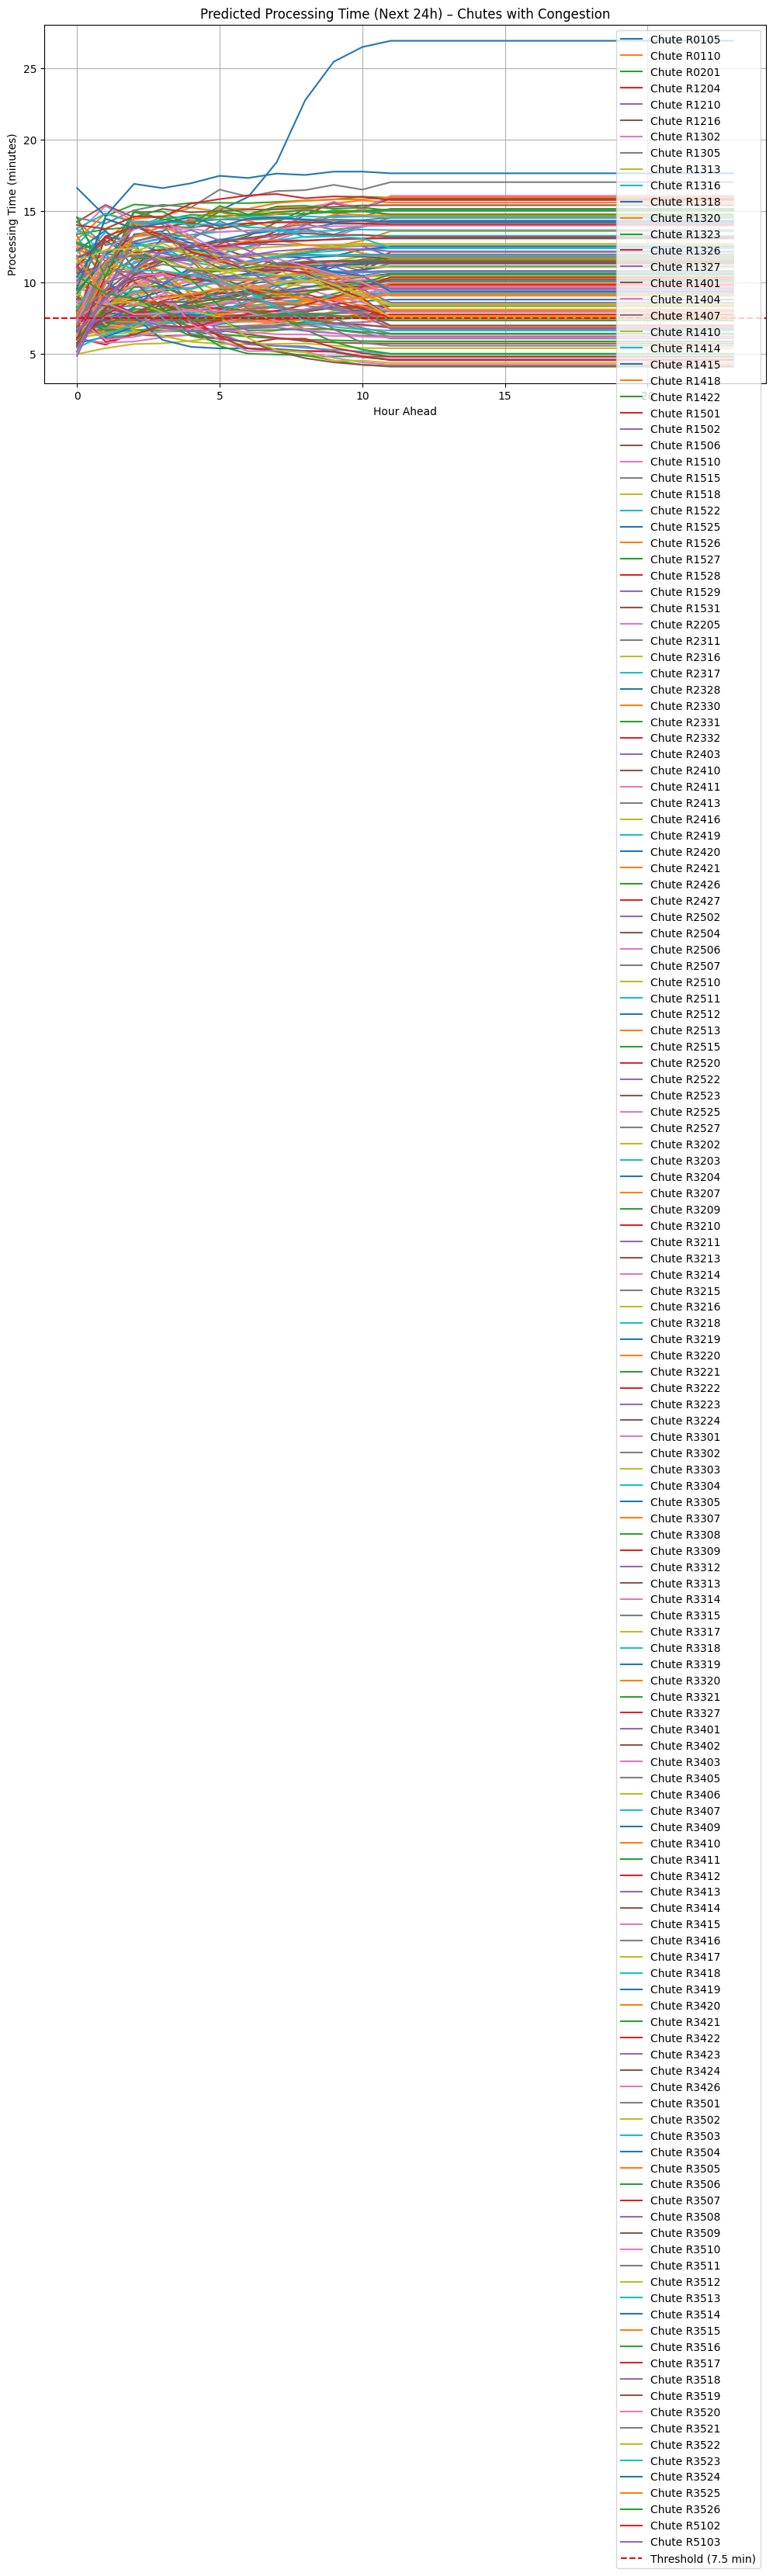

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# CONFIG
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_PATH = 'enhanced_lstm_model.pt'
SEQUENCE_LENGTH = 12
PREDICTION_HORIZON = 24
CONGESTION_THRESHOLD = 7.5

# === LSTM MODEL CLASS ===
class EnhancedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(EnhancedLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

# === Load trained model ===
input_size = len(final_features)
model = EnhancedLSTM(input_size=input_size).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# === Inference for each chute ===
results = {}

for chute_id in enriched_df['CHUTE'].unique():
    df_chute = enriched_df[enriched_df['CHUTE'] == chute_id].copy()
    if len(df_chute) < SEQUENCE_LENGTH:
        continue

    df_chute = df_chute.sort_values('HOUR_TIME')
    X_chute = df_chute[final_features].copy()
    X_scaled = scaler_X.transform(X_chute)

    last_seq = X_scaled[-SEQUENCE_LENGTH:]
    last_seq = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    future_preds = []
    for _ in range(PREDICTION_HORIZON):
        with torch.no_grad():
            pred = model(last_seq).item()
            future_preds.append(pred)

        # Repeat last input (for simulation)
        last_step = last_seq[0, -1, :].cpu().numpy()
        next_input = last_seq[0, 1:, :].cpu().numpy()
        next_input = np.vstack([next_input, last_step])
        last_seq = torch.tensor(next_input, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    # Inverse transform predictions
    preds_rescaled = scaler_y.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()

    if np.any(preds_rescaled > CONGESTION_THRESHOLD):
        results[chute_id] = preds_rescaled

# === Plot congested chutes ===
if results:
    plt.figure(figsize=(12, 6))
    for chute_id, preds in results.items():
        plt.plot(preds, label=f'Chute {chute_id}')
    plt.axhline(CONGESTION_THRESHOLD, color='red', linestyle='--', label='Threshold (7.5 min)')
    plt.title("Predicted Processing Time (Next 24h) – Chutes with Congestion")
    plt.xlabel("Hour Ahead")
    plt.ylabel("Processing Time (minutes)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("✅ No chutes predicted to exceed the congestion threshold.")


#"Upgraded" version of the LSTM Plots

<ipython-input-32-b066a66c519c>:79: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


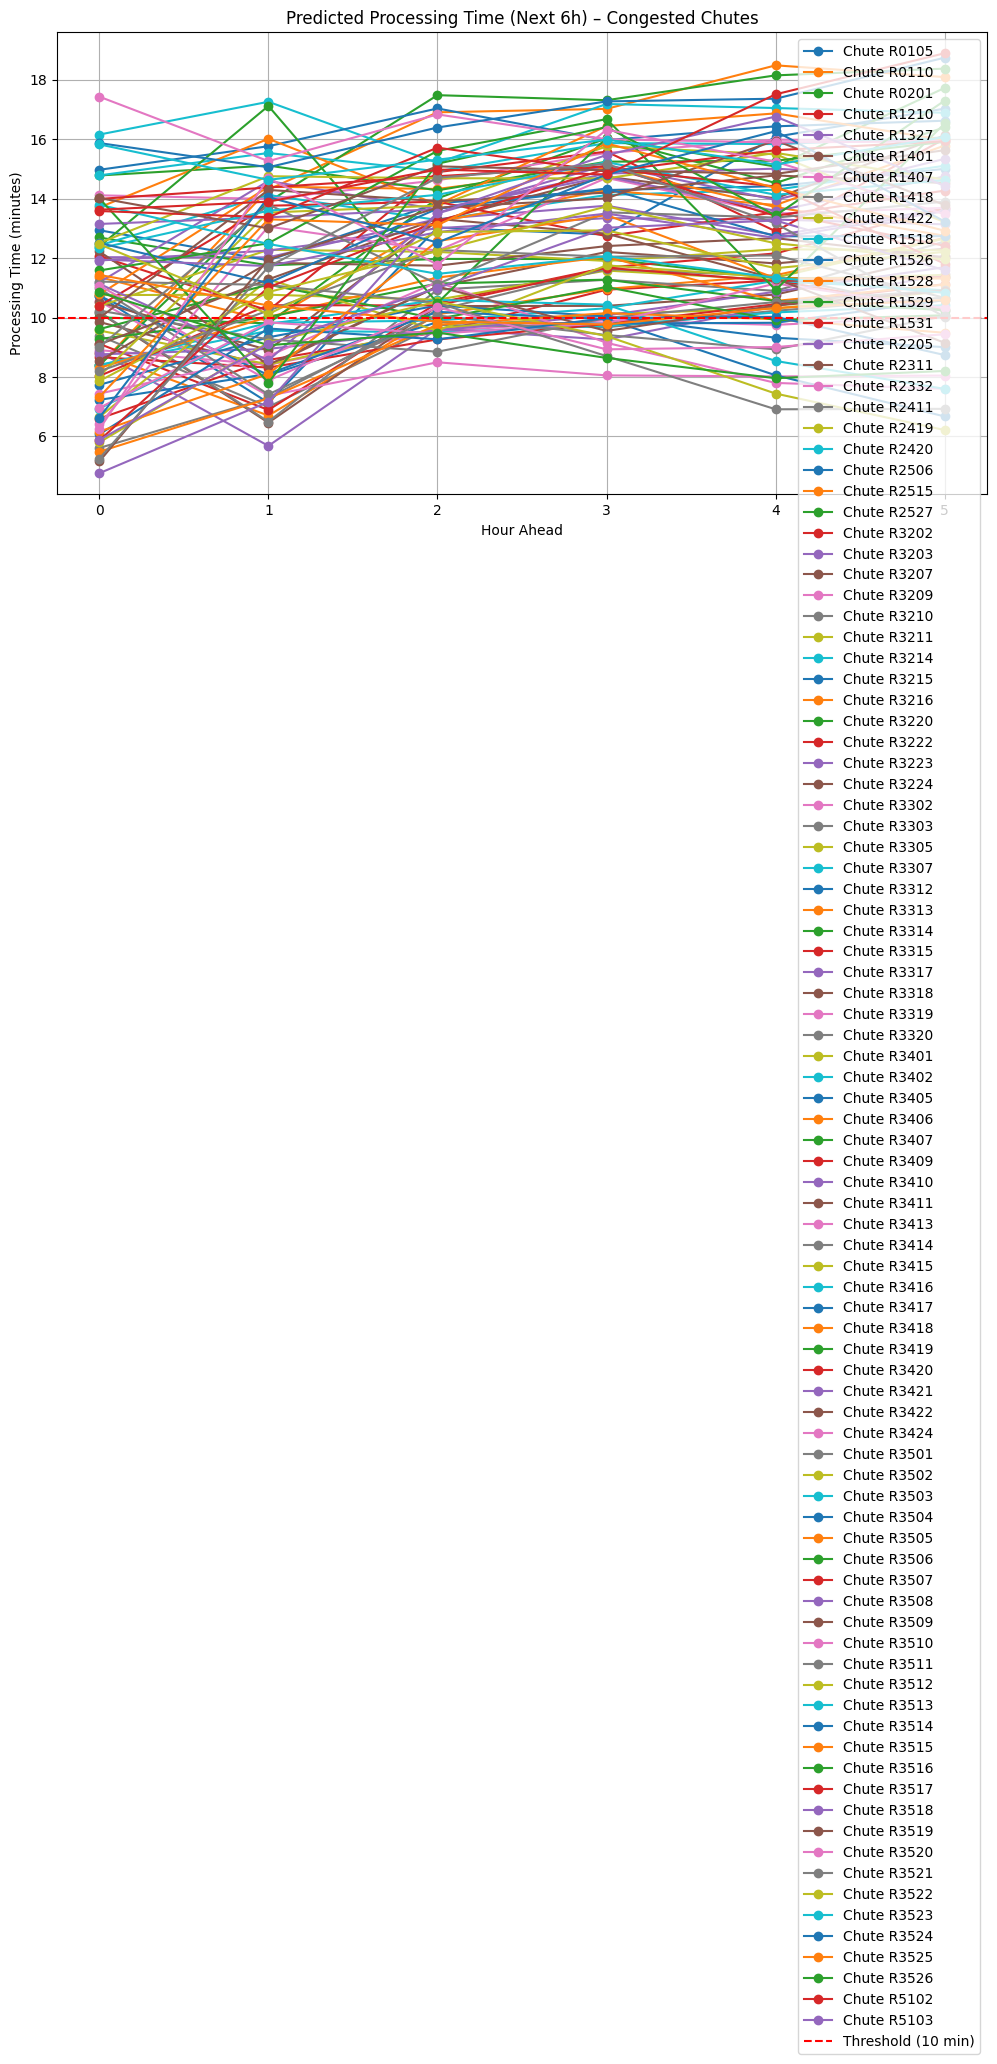

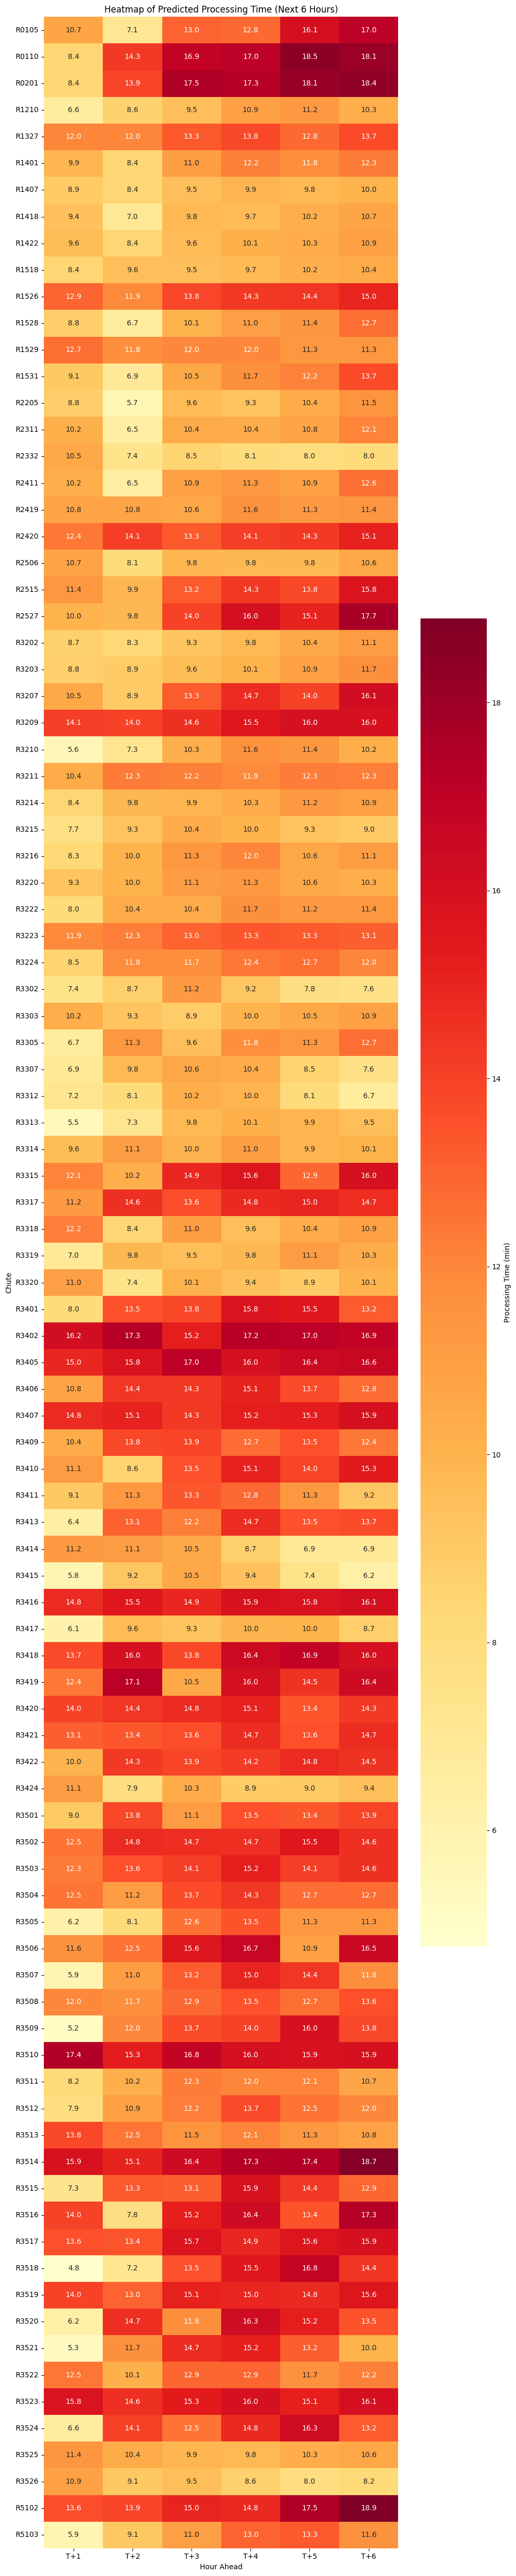

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# CONFIG
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_PATH = 'enhanced_lstm_model.pt'
SEQUENCE_LENGTH = 12
PREDICTION_HORIZON = 6
CONGESTION_THRESHOLD = 10

# === LSTM MODEL CLASS ===
class EnhancedLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(EnhancedLSTM, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, dropout=0.2)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(64, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

# === Load model ===
input_size = len(final_features)
model = EnhancedLSTM(input_size=input_size).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# === Predict for each chute ===
results = {}

for chute_id in enriched_df['CHUTE'].unique():
    df_chute = enriched_df[enriched_df['CHUTE'] == chute_id].copy()
    if len(df_chute) < SEQUENCE_LENGTH:
        continue

    df_chute = df_chute.sort_values('HOUR_TIME')
    X_chute = df_chute[final_features].copy()
    X_scaled = scaler_X.transform(X_chute)

    last_seq = X_scaled[-SEQUENCE_LENGTH:]
    last_seq = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    future_preds = []
    for _ in range(PREDICTION_HORIZON):
        with torch.no_grad():
            pred = model(last_seq).item()
            future_preds.append(pred)

        # Simulate future input by repeating last known input
        last_step = last_seq[0, -1, :].cpu().numpy()
        next_input = last_seq[0, 1:, :].cpu().numpy()
        next_input = np.vstack([next_input, last_step])
        last_seq = torch.tensor(next_input, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    preds_rescaled = scaler_y.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()

    if np.any(preds_rescaled > CONGESTION_THRESHOLD):
        results[chute_id] = preds_rescaled

# === Plot line chart for congested chutes ===
if results:
    plt.figure(figsize=(12, 6))
    for chute_id, preds in results.items():
        plt.plot(preds, marker='o', label=f'Chute {chute_id}')
    plt.axhline(CONGESTION_THRESHOLD, color='red', linestyle='--', label='Threshold (10 min)')
    plt.title("Predicted Processing Time (Next 6h) – Congested Chutes")
    plt.xlabel("Hour Ahead")
    plt.ylabel("Processing Time (minutes)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Create Heatmap ===
    heatmap_data = np.array(list(results.values()))
    chute_labels = list(results.keys())
    plt.figure(figsize=(10, len(chute_labels) * 0.5 + 2))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".1f",
        cmap="YlOrRd",
        xticklabels=[f"T+{i+1}" for i in range(PREDICTION_HORIZON)],
        yticklabels=chute_labels,
        cbar_kws={'label': 'Processing Time (min)'}
    )
    plt.title("Heatmap of Predicted Processing Time (Next 6 Hours)")
    plt.xlabel("Hour Ahead")
    plt.ylabel("Chute")
    plt.tight_layout()
    plt.show()

else:
    print("✅ No chutes predicted to exceed the congestion threshold.")


#Predicted vs. Actual Sorting Time

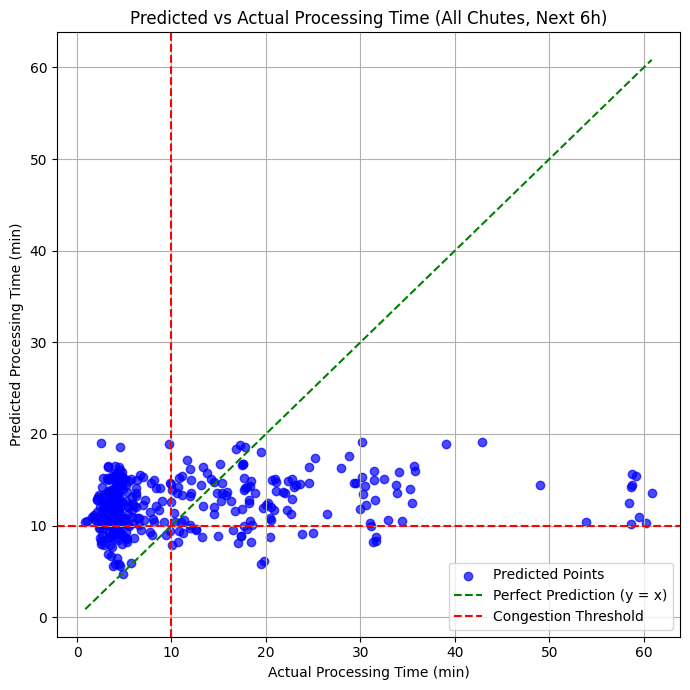

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# CONFIG
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_PATH = 'enhanced_lstm_model.pt'
SEQUENCE_LENGTH = 12
PREDICTION_HORIZON = 6
CONGESTION_THRESHOLD = 10

# === LSTM MODEL CLASS ===
class EnhancedLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(EnhancedLSTM, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, dropout=0.2)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(64, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

# === Load model ===
input_size = len(final_features)
model = EnhancedLSTM(input_size=input_size).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# === Predict and collect actuals for each chute ===
results = {}

for chute_id in enriched_df['CHUTE'].unique():
    df_chute = enriched_df[enriched_df['CHUTE'] == chute_id].copy()
    if len(df_chute) < SEQUENCE_LENGTH + PREDICTION_HORIZON:
        continue

    df_chute = df_chute.sort_values('HOUR_TIME')
    X_chute = df_chute[final_features].copy()
    X_scaled = scaler_X.transform(X_chute)

    last_seq = X_scaled[-(SEQUENCE_LENGTH + PREDICTION_HORIZON):-PREDICTION_HORIZON]
    last_seq = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    future_preds = []
    for _ in range(PREDICTION_HORIZON):
        with torch.no_grad():
            pred = model(last_seq).item()
            future_preds.append(pred)

        # Simulate future input
        last_step = last_seq[0, -1, :].cpu().numpy()
        next_input = last_seq[0, 1:, :].cpu().numpy()
        next_input = np.vstack([next_input, last_step])
        last_seq = torch.tensor(next_input, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    preds_rescaled = scaler_y.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()

    # Get actuals (if available)
    actuals = df_chute['AVG_PROCESSING_TIME_MINUTES'].values[-PREDICTION_HORIZON:]
    if len(actuals) == PREDICTION_HORIZON:
        if np.any(preds_rescaled > CONGESTION_THRESHOLD):
            results[chute_id] = {
                'preds': preds_rescaled,
                'actuals': actuals
            }

# === PLOT PREDICTED VS ACTUAL ===
# === COMBINED SCATTER PLOT: ALL CHUTES ===
if results:
    all_preds = []
    all_actuals = []
    all_chutes = []

    for chute_id, data in results.items():
        all_preds.extend(data['preds'])
        all_actuals.extend(data['actuals'])
        all_chutes.extend([chute_id] * len(data['preds']))

    plt.figure(figsize=(7, 7))
    scatter = plt.scatter(all_actuals, all_preds, c='blue', alpha=0.7, label='Predicted Points')

    # Perfect prediction line
    min_val = min(min(all_preds), min(all_actuals))
    max_val = max(max(all_preds), max(all_actuals))
    plt.plot([min_val, max_val], [min_val, max_val], color='green', linestyle='--', label='Perfect Prediction (y = x)')

    # Threshold reference
    plt.axhline(CONGESTION_THRESHOLD, color='red', linestyle='--', label='Congestion Threshold')
    plt.axvline(CONGESTION_THRESHOLD, color='red', linestyle='--')

    plt.xlabel("Actual Processing Time (min)")
    plt.ylabel("Predicted Processing Time (min)")
    plt.title("Predicted vs Actual Processing Time (All Chutes, Next 6h)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



# Added "Chat Box"

In [ ]:
import torch
import numpy as np

# === CONFIG ===
MODEL_PATH = 'enhanced_lstm_model.pt'
SEQUENCE_LENGTH = 12
CONGESTION_THRESHOLD = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# === LSTM MODEL CLASS ===
class EnhancedLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(EnhancedLSTM, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, dropout=0.2)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(64, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

# === PREDICTION FUNCTION ===
def predict_congestion(horizon: int):
    assert 1 <= horizon <= 6, "Horizon must be between 1 and 6"

    input_size = len(final_features)
    model = EnhancedLSTM(input_size=input_size).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()

    report = {}

    for chute_id in enriched_df['CHUTE'].unique():
        df_chute = enriched_df[enriched_df['CHUTE'] == chute_id].copy()
        if len(df_chute) < SEQUENCE_LENGTH:
            continue

        df_chute = df_chute.sort_values('HOUR_TIME')
        X_chute = df_chute[final_features].copy()
        X_scaled = scaler_X.transform(X_chute)

        last_seq = X_scaled[-SEQUENCE_LENGTH:]
        last_seq = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0).to(DEVICE)

        future_preds = []
        for _ in range(horizon):
            with torch.no_grad():
                pred = model(last_seq).item()
                future_preds.append(pred)

            # Simulate next step by repeating last known input
            last_step = last_seq[0, -1, :].cpu().numpy()
            next_input = last_seq[0, 1:, :].cpu().numpy()
            next_input = np.vstack([next_input, last_step])
            last_seq = torch.tensor(next_input, dtype=torch.float32).unsqueeze(0).to(DEVICE)

        preds_rescaled = scaler_y.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()

        # Collect congestion info
        congested = [(f"T+{i+1}", round(val, 2)) for i, val in enumerate(preds_rescaled) if val > CONGESTION_THRESHOLD]
        if congested:
            report[chute_id] = congested

    return report

# === USER INPUT ===
forecast_horizon = int(input("Enter forecast horizon (1–6 hours): "))
congestion_report = predict_congestion(forecast_horizon)

# === OUTPUT ===
if congestion_report:
    print(f"\n Congestion Detected in the Next {forecast_horizon} Hour(s):\n")
    for chute, hours in congestion_report.items():
        formatted = ", ".join([f"{t} ({v} min)" for t, v in hours])
        print(f"Chute {chute} → {formatted}")
else:
    print(f"\n No congestion predicted in the next {forecast_horizon} hour(s).")


Enter forecast horizon (1–6 hours): 2

 Congestion Detected in the Next 2 Hour(s):

Chute R0105 → T+1 (12.35 min)
Chute R0110 → T+2 (13.02 min)
Chute R0201 → T+2 (14.64 min)
Chute R1327 → T+1 (12.71 min), T+2 (11.5 min)
Chute R1422 → T+1 (10.12 min)
Chute R1526 → T+1 (13.74 min), T+2 (12.65 min)
Chute R1528 → T+1 (11.03 min)
Chute R1529 → T+1 (12.27 min), T+2 (11.7 min)
Chute R1531 → T+1 (11.23 min)
Chute R2205 → T+1 (10.32 min)
Chute R2311 → T+1 (10.89 min)
Chute R2411 → T+1 (11.67 min)
Chute R2419 → T+1 (11.87 min), T+2 (11.0 min)
Chute R2420 → T+1 (12.21 min), T+2 (12.92 min)
Chute R2506 → T+1 (10.85 min)
Chute R2515 → T+1 (12.83 min), T+2 (12.04 min)
Chute R2527 → T+1 (10.72 min), T+2 (10.51 min)
Chute R3207 → T+1 (12.58 min), T+2 (10.51 min)
Chute R3209 → T+1 (13.36 min), T+2 (13.72 min)
Chute R3211 → T+1 (11.23 min), T+2 (11.97 min)
Chute R3215 → T+2 (10.74 min)
Chute R3223 → T+1 (11.82 min), T+2 (12.16 min)
Chute R3224 → T+2 (11.26 min)
Chute R3301 → T+2 (10.12 min)
Chute R3302 